# Install and Import Necessary Dependencies

In [ ]:
# Eventually move all installs and imports to the top

!pip install torch
!pip install transformers pandas numpy

# Load Data

Data obtained from https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch?resource=download





In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import os
import pandas as pd

In [6]:
try:
  os.chdir('/content/drive/MyDrive/Personal Projects/Suicide Detection Dataset')
  print('Directory change successful')
except OSError:
  print('Directory change failed')

Directory change successful


In [26]:
# Load dataset
df = pd.read_csv('Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [27]:
df.shape

(232074, 3)

# Preprocess Data

Why?

Preprocessing standardizes the text so that computer models can better understand and work with human input. It also reduces computational complexity when model training. We want to avoid scenerios where words such as "Game" and "game" are counted as 2 different words.

Tasks:
- Fix spelling errors
- Change all letters to lowercase
- Remove stop words (words that do not contribute to the overall meaning of the text)
- Expand contractions (I've ➡ I have)
- Remove extra whitespaces
- Remove accents, URLs, symbols and digits




In [ ]:
!pip install unidecode contractions pyspellchecker wordninja symspellpy

In [11]:
import numpy as np
import nltk
import unidecode
import contractions
import wordninja
import re
import pkg_resources
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
# nltk.download('stopwords')

sym_spell = SymSpell(max_dictionary_edit_distance=3)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [12]:
from transformers.pipelines import text_generation
stop_words = stopwords.words('english')
selected_stop_words = [word for word in stop_words if word not in ['no', 'not']]

# Defining preprocessing methods

# Spell check and change to lowercase with Symspell
def fix_spelling(text):
  suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
  return suggestions[0].term

def remove_stop_words(text):
  return ' '.join([word for word in text.split(' ') if word not in stop_words])

def remove_whitespace(text):
  text = text.strip()
  return ' '.join(text.split())

def expand_contractions(text):
  return contractions.fix(text)

def remove_accents(text):
  return unidecode.unidecode(text)

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

def remove_symbols_digits(text):
  return re.sub('[^a-zA-Z\s]', ' ', text)

def remove_special(text):
  return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocessing(text):
  text = fix_spelling(text)
  text = remove_stop_words(text)
  text = remove_whitespace(text)
  text = expand_contractions(text)
  text = remove_accents(text)
  text = remove_urls(text)
  text = remove_symbols_digits(text)
  text = remove_special(text)
  return text

# Preprocess all the data
df['cleaned_text'] = df['text'].apply(lambda row: text_preprocessing(row))
df[:20]

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threatening suicide recently left wif...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,8,i need helpjust help me im crying so hard,suicide,need help help crying hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name adam i have struggling yea...
5,11,Honetly idkI dont know what im even doing here...,suicide,honestly id done know even feel like nothing n...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warning excuse self inflicted burns kn...
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,ends tonight cannot anymore quit
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,everyone wants edgy making self conscious feel...
9,18,My life is over at 20 years oldHello all. I am...,suicide,life years old hello year old balding male hai...


# Data Exploration



Tasks:
- Sentinment analysis using TextBlob's Sentinment() function (-1 represents a negative attitude and +1 represents a positive attitude)
- Term frequency analysis


# Sentiment Analysis

In [13]:
from textblob import TextBlob

df_sentiment_analysis = df.copy()
df_sentiment_analysis['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sentiment_analysis.head()

,Unnamed: 0,text,class,cleaned_text,sentiment
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threatening suicide recently left wif...,0.116667
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...,0.100000
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...,-0.525000
3,8,i need helpjust help me im crying so hard,suicide,need help help crying hard,-0.245833
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name adam i have struggling yea...,-0.221131


# Term Frequency and Word Cloud

In [14]:
df_term_freq = df.copy()
df_term_freq['split_text'] = df['cleaned_text'].apply(lambda row: row.split(' '))

In [21]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

words = df_term_freq['split_text']
all_words = []
for word_list in words:
  all_words += word_list

all_words = list(filter(None, all_words))

most_common = FreqDist(all_words).most_common(100)
print(most_common)

[('i', 365769), ('am', 221219), ('like', 182587), ('want', 166003), ('know', 133111), ('life', 123845), ('feel', 122891), ('have', 114157), ('get', 112403), ('cannot', 109349), ('would', 104958), ('people', 94477), ('even', 91425), ('time', 90202), ('one', 89811), ('ism', 89399), ('going', 85178), ('really', 83822), ('is', 73241), ('think', 72333), ('go', 68722), ('never', 67424), ('friends', 62350), ('day', 61496), ('much', 60885), ('help', 60186), ('filler', 55690), ('years', 52880), ('got', 49761), ('things', 49492), ('done', 49326), ('make', 48186), ('anymore', 47604), ('fucking', 47597), ('good', 47441), ('school', 47398), ('could', 46974), ('someone', 46503), ('live', 46147), ('anything', 45963), ('way', 45174), ('back', 44372), ('still', 43174), ('see', 43058), ('everything', 42526), ('something', 42369), ('will', 42147), ('die', 41771), ('every', 41245), ('need', 41086), ('family', 40958), ('fuck', 40957), ('better', 40714), ('nothing', 40603), ('always', 40565), ('anyone', 397

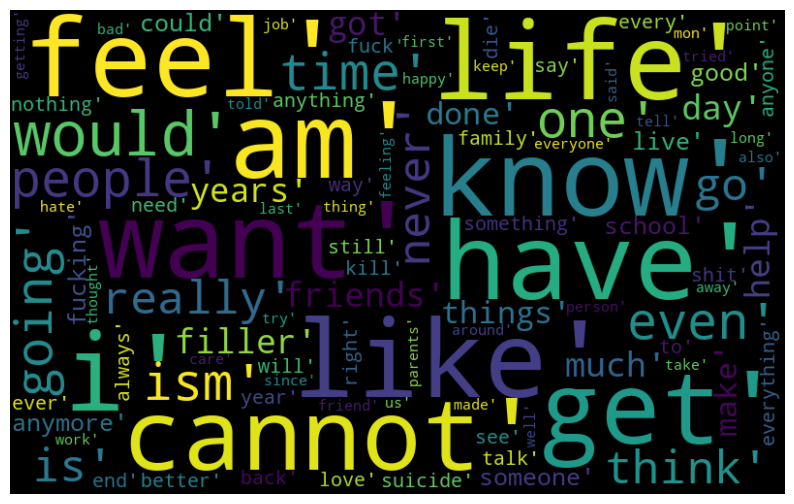

In [20]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(most_common))
fig = plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Fine-tuning BERT

In [28]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda")
SEED = 2023

## Split the Dataset into Training, Validation, and Test Sets

In [36]:
x_train, x_temp, y_train, y_temp = train_test_split(df['text'], df['class'], random_state=SEED, test_size=0.2, stratify=df['class'])

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=SEED, test_size=0.5, stratify=y_temp)

## Import BERT Model and Tokenizer 

In [37]:
model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
